## Linear Activity vs Dyskinesia and multi-freq Biomarker Prediction


In [ ]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from itertools import compress, product
import pandas as pd
import numpy as np
import sklearn as sk
from scipy import signal, stats

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [ ]:
projectpath = get_project_path_in_notebook()


Import own functions

In [ ]:
os.chdir(os.path.join(projectpath, 'code'))

# own utility functions
import utils.utils_fileManagement as utilsFiles

# own data exploration functions
import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.ft_processing_helpers as ftProc
import lfpecog_analysis.psd_lid_stats as lidStats
import lfpecog_analysis.ft_processing_helpers as ftProc
import lfpecog_features.feats_spectral_helpers as specHelp
import lfpecog_analysis.get_acc_task_derivs as getAccTask

import lfpecog_predict.prepare_predict_arrays as predArrays
import lfpecog_features.extract_ssd_features as ssdFeats
import lfpecog_analysis.stats_fts_lid_corrs as ft_stats
from lfpecog_plotting.plotHelpers import get_colors
import lfpecog_plotting.plotHelpers as pltHelp
import lfpecog_plotting.plot_SSD_feat_descriptives as plot_ssd_descr

check versions

In [ ]:
from  matplotlib import __version__ as plt_version

# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('matplotlib', plt_version)
# Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
# pandas 1.4.4
# numpy 1.23.3
# matplotlib 3.5.3

### Import data

imports SSD-band-envelops with parallel CDRS, timestamps, task, movement-coding

In [ ]:
# SET VERSIONS

FT_VERSION='v8'
SETTINGS = utilsFiles.load_ft_ext_cfg(FT_VERSION=FT_VERSION)

SUBS = utilsFiles.get_avail_ssd_subs(
    DATA_VERSION=SETTINGS["DATA_VERSION"],
    FT_VERSION=FT_VERSION,
)
print(f'n = {len(SUBS)} subjects available')

## FIG: Spectral Scatterplot: Movement vs. Dyskinesia dependence

Load STN data (n=21)

In [ ]:
FT_VERSION = 'v8'
INCL_CORE_CDRS = True
CATEG_CDRS = False
INCL_ECOG = False  # if True, STN-only patients are NOT included
MILD_CDRS = 4  # cut off for dyskinesia categorization (4)
SEV_CDRS = 8  # cut off for dyskinesia categorization (8)

# ### Create Feature Class
# FeatLid_STN = ftProc.FeatLidClass(
#     FT_VERSION=FT_VERSION,
#     CDRS_RATER='Patricia',
#     INCL_ECOG=INCL_ECOG,
#     INCL_ACC_RMS=False,
#     CATEGORICAL_CDRS=CATEG_CDRS,
#     CORR_TARGET='CDRS',
#     cutMild=MILD_CDRS, cutSevere=SEV_CDRS,
#     TO_CALC_CORR=False,
# )

### LOAD existing classes with features and labels
featLabPath = os.path.join(utilsFiles.get_project_path('data'),
                           'prediction_data',
                           'featLabelClasses')
stn_pickle = f'featLabels_ft{FT_VERSION}_Cdrs_StnOnly.P'

FeatLid_STN = utilsFiles.load_class_pickle(
    os.path.join(featLabPath, stn_pickle),
    convert_float_np64=True
)


# MERGE GAMMA1-2-3 FEATURES
for sub in FeatLid_STN.FEATS:
    FeatLid_STN.FEATS[sub] = ft_stats.replace_gammas_for_meanGamma(FeatLid_STN.FEATS[sub])



In [ ]:
### Load Feature Class for Acc (v6)

### Create 
# Acc_STN = ftProc.FeatLidClass(
#     FT_VERSION='v6',
#     CDRS_RATER='Patricia',
#     INCL_ECOG=INCL_ECOG,
#     INCL_ACC_RMS=True,
#     CATEGORICAL_CDRS=CATEG_CDRS,
#     CORR_TARGET='CDRS',
#     cutMild=MILD_CDRS, cutSevere=SEV_CDRS,
#     TO_CALC_CORR=False,
# )


# Load v6 to get ACC-values
Acc_STN = utilsFiles.load_class_pickle(
    os.path.join(featLabPath, stn_pickle.replace('v8', 'v6')),
    convert_float_np64=True
)

Load ECoG data (n=13)

In [ ]:
FT_VERSION = 'v8'
INCL_CORE_CDRS = True
CATEG_CDRS = False
INCL_ECOG = True  # if True, STN-only patients are NOT included
MILD_CDRS = 4  # cut off for dyskinesia categorization
SEV_CDRS = 8  # cut off for dyskinesia categorization

### Create Feature Class
# FeatLid_ECOG = ftProc.FeatLidClass(
#     FT_VERSION=FT_VERSION,
#     CDRS_RATER='Patricia',
#     INCL_ECOG=INCL_ECOG,
#     INCL_ACC_RMS=False,
#     CATEGORICAL_CDRS=CATEG_CDRS,
#     CORR_TARGET='CDRS',
#     cutMild=MILD_CDRS, cutSevere=SEV_CDRS,
#     TO_CALC_CORR=False,
# )

### LOAD existing classes with features and labels
featLabPath = os.path.join(utilsFiles.get_project_path('data'),
                           'prediction_data',
                           'featLabelClasses')
ecog_pickle = f'featLabels_ft{FT_VERSION}_Cdrs_Ecog.P'

FeatLid_ECOG = utilsFiles.load_class_pickle(
    os.path.join(featLabPath, ecog_pickle),
    convert_float_np64=True
)
# MERGE GAMMA1-2-3 FEATURES
for sub in FeatLid_ECOG.FEATS:
    FeatLid_ECOG.FEATS[sub] = ft_stats.replace_gammas_for_meanGamma(FeatLid_ECOG.FEATS[sub])



# Load v6 to get ACC-values
Acc_ECOG = utilsFiles.load_class_pickle(
    os.path.join(featLabPath, ecog_pickle.replace('v8', 'v6')),
    convert_float_np64=True
)


Get task data per minute

In [ ]:
TASK_MINS = getAccTask.get_task_minutes(LOAD_JSON=True, SUBS=SUBS)

In [ ]:
import lfpecog_plotting.plot_Spectrals_vs_LID as plotSpecLid

Plot Scatterplot

In [ ]:
importlib.reload(ftProc)
importlib.reload(plotSpecLid)

FIG_DATE = '1009'

POW_or_COH = 'COH'  # POW or COH
SRC = 'ecog'  # ecog or lfp
EXCL_FREE = False
gamma_peak = 'peak'  # peak / mean

if SRC == 'lfp':
    FeatClass = FeatLid_STN  # FeatLid_ECOG
    AccClass = Acc_STN
if SRC == 'ecog':
    FeatClass = FeatLid_ECOG
    AccClass = Acc_ECOG

FIG_NAME = (f'{FIG_DATE}_PowerScatter_{SRC.upper()}_LID_MOVE_g{gamma_peak}'
            f'_n{len(FeatClass.FEATS.keys())}_ft{FT_VERSION}_shf')
if EXCL_FREE: FIG_NAME = 'woFREE_' + FIG_NAME

plotSpecLid.scatter_Feats_LID_MOVE(
    FeatClass=FeatClass,
    AccClass=AccClass,
    POW_or_COH=POW_or_COH,
    SRC=SRC,
    SHUFFLE_SCATTERS=True,
    SAVE_FIG=True,
    FIG_NAME=FIG_NAME,
    gamma_mean_or_peakband=gamma_peak,
    EXCL_FREE=EXCL_FREE,
    task_minutes=TASK_MINS,
    ZERO_SPACE=True,
)

## FIG) Simple biomarker versus Dyskinesia onset


Calculates based on envelop arrays from predArrays.get_move_selected_env_arrays()

In [ ]:
from lfpecog_analysis.psd_analysis_classes import PSD_vs_Move_sub

In [ ]:
importlib.reload(predArrays)

# get move-selected env arrays
# contains: freq-bands, CDRS, timestamps, tasks, mov-coding

# TODO: FIRST extract via cmd: lfpecog_predict.prepare_precit_arrays
DATA, env_fbands = {}, {}

for sub in SUBS:
    DATA[sub], env_fbands[sub] = predArrays.get_move_selected_env_arrays(
        sub=sub, LOAD_SAVE=True,
        FT_VERSION='v8',
    )

Prepare data

In [ ]:
src = 'lfp_left'

ex_sub = list(env_fbands.keys())[0]
ex_src= list(env_fbands[ex_sub].keys())[0]

i_theta = np.where([k == 'theta' for k in env_fbands[sub][src]])[0][0]
i_beta = np.where([k == 'lo_beta' for k in env_fbands[sub][src]])[0][0]
i_gammaPeak = np.where([k == 'gammaPeak' for k in env_fbands[sub][src]])[0][0]
i_cdrs = len(env_fbands[sub][src])
i_time = i_cdrs + 1
i_task = i_time + 1
# i_move is last

time_list = {'lid': [], 'nolid': []}
ratio_list = {'lid': [], 'nolid': []}

lid_onsets = []

sub_list = []

for sub, src in product(DATA.keys(),
                        ['lfp_left', 'lfp_right']):
    
    if sum(DATA[sub][src][i_cdrs, :]) == 0:
        print(f'sub {sub} had no LID')
        subgroup = 'nolid'
    else:
        subgroup = 'lid'

    print(f'...calc {sub, src}')
    
    idx_sort = np.argsort(DATA[sub][src][i_time, :])
    sort_arr = DATA[sub][src][:, idx_sort]

    theta = sort_arr[i_theta, :]
    beta = sort_arr[i_beta, :]
    gamma = sort_arr[i_gammaPeak, :]


    for arr in [theta, beta, gamma]:
        off_sel = sort_arr[i_time, :] < 5
        m = np.mean(arr[off_sel])
        sd = np.std(arr[off_sel])
        arr = (arr - m) / sd

    assert theta.shape == beta.shape, 'shapes unequal'

    # sets all times to ZERO at LID onset
    if subgroup == 'lid':
        i0_lid = np.where(sort_arr[i_cdrs, :] > 0)[0][0]
        t0_lid = sort_arr[i_time, i0_lid]
        lid_times = sort_arr[i_time, :] - t0_lid
        lid_onsets.append(t0_lid)
    else:
        lid_times = sort_arr[i_time, :]


    time_list[subgroup].append(lid_times)
    ratio = (theta / beta) * gamma
    ratio = (ratio - np.mean(ratio)) / np.std(ratio)
    ratio_list[subgroup].append(ratio)

    sub_list.append(f'{sub}_{src}')


In [ ]:
min_sec, max_sec = (
    int(np.min([np.min(l) for l in time_list['lid']])),
    int(np.max([np.max(l) for l in time_list['lid']]))
)

print(f'mean LID onset: {round(np.mean(lid_onsets) / 60, 1)} minutes'
      f' (sd: {round(np.std(lid_onsets) / 60, 1)})')
# correct group without LID to comparable time offsets
nolid_new_times = []
for t in time_list['nolid']:
    nolid_new_times.append(t - np.mean(lid_onsets))


In [ ]:
# create overall array per X seconds
WIN_LEN = 10

## LID group
min_sec, max_sec = (
    int(np.min([np.min(l) for l in time_list['lid']])),
    int(np.max([np.max(l) for l in time_list['lid']]))
)
t_new = np.arange(min_sec, max_sec, WIN_LEN)

ratio_arr = np.array([[np.nan] * len(t_new)] * len(ratio_list['lid']))

for i_t, t0 in enumerate(t_new):

    for i_row, (sig_temp, t_temp) in enumerate(
        zip(ratio_list['lid'], time_list['lid'])
    ):
        # select idx for window
        win_sel = np.logical_and(t_temp > t0, t_temp < (t0 + WIN_LEN))
        # add mean ratio to correct idx
        ratio_arr[i_row, i_t] = np.mean(sig_temp[win_sel])


## NO-LID group

# correct group without LID to comparable time offsets
nolid_new_times = []
for t in time_list['nolid']:
    nolid_new_times.append(t - np.mean(lid_onsets))

ratio_arr_noLID = np.array([[np.nan] * len(t_new)] * len(ratio_list['nolid']))

# use same time frame
for i_t, t0 in enumerate(t_new):

    for i_row, (sig_temp, t_temp) in enumerate(
        zip(ratio_list['nolid'], nolid_new_times)
    ):
        # select idx for window
        win_sel = np.logical_and(t_temp > t0, t_temp < (t0 + WIN_LEN))
        # add mean ratio to correct idx
        ratio_arr_noLID[i_row, i_t] = np.mean(sig_temp[win_sel])
        

Plot Ratio over Time vs LID-onset

In [ ]:
importlib.reload(plotSpecLid)

# plot_ratio_biomarker(ratio_arr=ratio_arr,
#                      Z_SCORE_RATIOS=False,
#                      MIN_SUBS=5,
#                      SMOOTH_WIN=0,)

plotSpecLid.plot_ratio_biomarker(
    ratio_arr=ratio_arr,
    t_new=t_new,
    Z_SCORE_RATIOS=False,
    MIN_SUBS=5,
    SMOOTH_WIN=10,
    SAVE_FIG=False,
)

# plot_ratio_biomarker(ratio_arr=ratio_arr_noLID,
#                      Z_SCORE_RATIOS=False, MIN_SUBS=2)

Calculate binary AUROC

In [ ]:
# remove no-lid-subjects from sub_list
sub_list = [s for s in sub_list if 
            all(c not in s for c in ['101', '017', '109'])]

thresholds = np.arange(-.5, .9, .001)

auroc = []

for sub in np.unique([s.split('_')[0] for s in sub_list]):
    
    sub_roc = []
    
    # print(f'sub-{sub}')
    sub_sel = [sub in s for s in sub_list]
    sub_arr = np.mean(ratio_arr.copy()[sub_sel], axis=0)
    sub_t = t_new.copy()
    sel = [not np.isnan(v) for v in sub_arr]
    sub_arr = sub_arr[sel]
    sub_t = sub_t[sel]
    sub_y_true = (sub_t > 0).astype(int)

    for t in thresholds:
        y_pred = (sub_arr > t).astype(int)
        tp = sum(np.logical_and(y_pred == 1, sub_y_true == 1))
        fn = sum(np.logical_and(y_pred == 0, sub_y_true == 1))
        tpr = tp / (tp + fn)
        fp = sum(np.logical_and(y_pred == 1, sub_y_true == 0))
        tn = sum(np.logical_and(y_pred == 0, sub_y_true == 0))
        fpr = fp / (fp + tn)
        sub_roc.append([fpr, tpr])
    
    auroc.append(sub_roc)

    

In [ ]:
# Plot single AUROCs
for roc in auroc:
    roc = np.array(roc)
    plt.plot(roc[:, 0], roc[:, 1], alpha=.3,)

plt.xlim(-.05, 1.05)
plt.ylim(-.05, 1.05)

# change level
plt.plot([0, 1], [0, 1], lw=3, alpha=.8, color='gray',
         ls='--',)

plt.xlabel('False pos. rate', size=16, weight='bold',)
plt.ylabel('True pos. rate', size=16, weight='bold',)

plt.title('AUROC based on [ \u03B8 * \u03B2 / \u03B3 ] ratio',
          size=16, weight='bold',)

FIG_PATH = os.path.join(utilsFiles.get_project_path('figures'),
                            'final_Q1_2024',
                            'prediction', 'ratio')
            
plt.savefig(os.path.join(FIG_PATH, '000_RATIO_AUROC_v6'),
            dpi=300, facecolor='w',)

plt.close()

In [ ]:
# Plot Mean AUROC
SAVEFIG=True
FIG_DATE='0918'

all_aurocs = np.array(auroc)

mean_roc = np.mean(all_aurocs, axis=0)
sd_roc = np.std(all_aurocs, axis=0)

plt.plot(mean_roc[:, 0], mean_roc[:, 1],
         c='k', alpha=.8, lw=3,)

plt.fill_between(x=mean_roc[:, 0],
                 y1=mean_roc[:, 1] - sd_roc[:, 1],
                 y2=mean_roc[:, 1] + sd_roc[:, 1],
                 color='gray', alpha=.4, lw=0,)

plt.xlim(-.05, 1.05)
plt.ylim(-.05, 1.05)

# change level
plt.plot([0, 1], [0, 1], lw=3, alpha=.8, color='gray',
         ls='--',)

plt.xlabel('False pos. rate', size=16, weight='bold',)
plt.ylabel('True pos. rate', size=16, weight='bold',)

plt.title('AUROC based on [ \u03B8 * \u03B2 / \u03B3 ] ratio',
          size=16, weight='bold',)

FIG_PATH = os.path.join(utilsFiles.get_project_path('figures'),
                            'final_Q1_2024',
                            'prediction', 'ratio')
if SAVEFIG:          
    plt.savefig(os.path.join(FIG_PATH, f'{FIG_DATE}_RATIO_meanAUROC_v6'),
                dpi=300, facecolor='w',)
    plt.close()
else:
    plt.show()

### Leave-one-subject-out Cross-Validation of Ratio-Biomarker

Prepare Data: mean LFP Ratio with binary-LID for every subject

- single spectral bands are standardised against their first 5 minutes
- ecpohed mean-envelop values are saved as json files per STN (L vs R)
- epoch length is variable (default 10 seconds)
- envelop-ratio calculated on high-sampling rate, then per hemisphere ecpohed mean, then mean over both hemispheres for identical epoch-times (rounded on 10 seconds)

In [ ]:
import json


In [ ]:
def load_ratios_json(sub, src, version='v1',):

    try:
        path = os.path.join(projectpath, 'data', 'prediction_data', 'ratio_marker')
        if version == 'v2':
            path = os.path.join(projectpath, 'data', 'prediction_data', 'ratio_marker_v2')
        f_name = f'{sub}_{src}_ratio_data.json'

        with open(os.path.join(path, f_name), 'r') as f:
            temp = json.load(f)
        
        print(f'successfully loaded loading {f_name} from {path}!')

        return True, temp

    except:
        print(f'could not load RATIO-json {f_name} from {path}')

        return False, False


def save_ratios_json(sub, src, data_dict, version='v1'):

    path = os.path.join(projectpath, 'data', 'prediction_data', 'ratio_marker')
    if version == 'v2':
        path = os.path.join(projectpath, 'data', 'prediction_data', 'ratio_marker_v2')
    f_name = f'{sub}_{src}_ratio_data.json'

    with open(os.path.join(path, f_name), 'wt') as f:
        json.dump(data_dict, f)

In [298]:
def calc_unilat_ratio_markers(
    sub, src, env_fbands,DATA, WIN_LEN=10,
):
    i_theta = np.where([k == 'theta' for k in env_fbands[sub][src]])[0][0]
    i_beta = np.where([k == 'lo_beta' for k in env_fbands[sub][src]])[0][0]
    i_gammaPeak = np.where([k == 'gammaPeak' for k in env_fbands[sub][src]])[0][0]
    i_cdrs = len(env_fbands[sub][src])
    i_time = i_cdrs + 1
    i_task = i_time + 1

    idx_sort = np.argsort(DATA[sub][src][i_time, :])
    sort_arr = DATA[sub][src][:, idx_sort]

    # get spectral bands
    theta = sort_arr[i_theta, :]
    beta = sort_arr[i_beta, :]
    gamma = sort_arr[i_gammaPeak, :]

    # standardise bands separately (against 'OFF')
    for arr in [theta, beta, gamma]:
        off_sel = sort_arr[i_time, :] < 5
        m = np.mean(arr[off_sel])
        sd = np.std(arr[off_sel])
        arr = (arr - m) / sd

    assert theta.shape == beta.shape, 'shapes unequal'

    # add unilateral ratio, not z-scored
    ratio = (theta / beta) * gamma

    # define binary LID
    temp_lid = sort_arr[i_cdrs, :] > 0
    
    # add times to check matching sides
    temp_times = sort_arr[i_time, :]

    # MERGE VALUES INTO X-sec EPOCHS
    time_range = np.arange(round(min(temp_times), -1),
                        round(max(temp_times), -1), WIN_LEN)
    new_ratios, new_lid, new_times = [], [], []
    
    t_start = round(min(temp_times), -1)

    while (t_start + WIN_LEN) < round(max(temp_times), -1):
        # print('new loop:', t_start)
        t_start = round(t_start, -1)
        t_end = t_start + WIN_LEN
        i_start = np.argmin(abs(temp_times - t_start))
        i_end = np.argmin(abs(temp_times - t_end))
        
        if (i_end - i_start) < 2000:
            t_start = temp_times[i_end + 2000]
            print(f'too small epoch, jump to time = {t_start}')
            continue
        
        print('adding..........', t_start, t_end, (i_end-i_start))
        new_ratios.append(np.mean(ratio[i_start:i_end]))
        new_lid.append(any(temp_lid[i_start:i_end] > 0))
        new_times.append(t_start)
        t_start += WIN_LEN


    # STORE PER SUB SOURCE IN PICKLE
    ind_src_dict = {
        "sub": sub,
        "src": src,
        "times": new_times,
        "lid": new_lid,
        "ratio": new_ratios
    }
    save_ratios_json(sub=sub, src=src, data_dict=ind_src_dict,)

    return new_times, new_lid, new_ratios

In [211]:
def prepare_markers_laterality(
    temp_lid, temp_times, temp_ratio, sub,
    UNILAT_MARKER=False, ZSCORE=False,):

    if UNILAT_MARKER:

        f = os.path.join(utilsFiles.get_onedrive_path('data'), 'clinical scores', 'severe_sides.json')
        with open(f, 'r') as f:
            lid_side = json.load(f)[sub]
        if lid_side == 'left': stn_side = 'right'
        elif lid_side == 'right': stn_side = 'left'
        else: stn_side = 'left'  # nan for no dysk

        sub_lid = temp_lid[f'lfp_{stn_side}']
        sub_times = temp_times[f'lfp_{stn_side}']
        sub_ratio = temp_ratio[f'lfp_{stn_side}']

        print(f'only included lfp-{stn_side} for sub-{sub}')


    else:
        sub_lid = temp_lid['lfp_left']
        sub_times = temp_times['lfp_left']  # for posthoc LID-binary correction based on time

        if len(temp_ratio['lfp_left']) != len(temp_ratio['lfp_right']):
            print(f'correct different ratio lengths L/R')
            # INCLUDE ONLY MUTUAL TIMES!
            incl_left = np.isin(temp_times['lfp_left'],
                                temp_times['lfp_right'])
            incl_right = np.isin(temp_times['lfp_right'],
                                temp_times['lfp_left'])
            
            # select ratio values corresponding to mutual times
            temp_ratio['lfp_left'] = temp_ratio['lfp_left'][incl_left]
            temp_ratio['lfp_right'] = temp_ratio['lfp_right'][incl_right]
            
            # select binary lid corr to times and ratios
            sub_lid = temp_lid['lfp_left'][incl_left]
            sub_times = temp_times['lfp_left'][incl_left]
            
        sub_ratio = np.mean([temp_ratio['lfp_left'],
                              temp_ratio['lfp_right']], axis=0)
        
        assert len(sub_ratio) == len(sub_lid)

        if ZSCORE: sub_ratio = (sub_ratio - np.mean(sub_ratio)) / np.std(sub_ratio)  # z-score mean ratio

    if RATIO_V == 'v1':  # correct false binary values
        cdrs_times, cdrs_scores = importClin.get_cdrs_specific(sub=sub, INCL_CORE_CDRS=True,)
        cdrs_times *= 60  # correct minutes to seconds
        corr_lid = [cdrs_scores[np.argmin(abs(cdrs_times - t))] for t in sub_times]  # match ratio times to closest-cdrs
        sub_lid = np.array(corr_lid) > 0

    return sub_lid, sub_times, sub_ratio

In [296]:
"""
test with unilateral z-scoring
"""
UNILAT_MARKER = True
RATIO_V = 'v1'

WIN_LEN = 10

ratio_arrays = {}  # collect mean ratios left-right STN
lid_arrays = {}  # collect mean ratios left-right STN
time_arrays = {}


for sub in DATA.keys():

    temp_ratio = {}  # collect mean ratios left-right STN
    temp_times = {}  # collect timestamps to check left-right match
    temp_lid = {}

    for src in ['lfp_left', 'lfp_right']:

        LOAD_SUCCESS, temp_dict = load_ratios_json(sub=sub, src=src,)

        if LOAD_SUCCESS:
            assert temp_dict["sub"] == sub, f'incorrect sub loaded {temp_dict[sub]} vs {sub}'
            assert temp_dict["src"] == src, f'incorrect sub loaded {temp_dict[src]} vs {src}'
            temp_ratio[src] = np.array(temp_dict['ratio'])
            temp_times[src] = np.array(temp_dict['times'])
            temp_lid[src] = np.array(temp_dict['lid'])
            continue
        
        # Calculate and store IF LOADING WAS NOT successful....:
        print(f'...calc {sub, src}')
        new_times, new_lid, new_ratios = calc_unilat_ratio_markers(
            sub, src, env_fbands,DATA, WIN_LEN=10,
        )
        # replace with epoched values
        temp_ratio[src] = np.array(new_ratios)
        temp_lid[src] = np.array(new_lid)
        temp_times[src] = np.array(new_times)

    # get markers based on LATERALITY
    sub_lid, sub_times, sub_ratio = prepare_markers_laterality(
        temp_lid, temp_times, temp_ratio, sub,
        UNILAT_MARKER=UNILAT_MARKER, ZSCORE=False,
    )
    ratio_arrays[sub] = sub_ratio
    lid_arrays[sub] = sub_lid  # add binary dysk per sub
    time_arrays[sub] = sub_times  # add binary dysk per sub

successfully loaded loading 108_lfp_left_ratio_data.json from c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\prediction_data\ratio_marker!
successfully loaded loading 108_lfp_right_ratio_data.json from c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\prediction_data\ratio_marker!
only included lfp-left for sub-108
successfully loaded loading 014_lfp_left_ratio_data.json from c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\prediction_data\ratio_marker!
successfully loaded loading 014_lfp_right_ratio_data.json from c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\prediction_data\ratio_marker!
only included lfp-left for sub-014
successfully loaded loading 022_lfp_left_ratio_data.json from c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\prediction_data\ratio_marker!
successfully loaded loading 022_lfp_right_ratio_data.json from c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\prediction_data\ratio_marker!
only incl

Full AUROC without Cross-Validation

C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\1265986606.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)  # TPR = sens
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\1265986606.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)  # TPR = sens
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\1265986606.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)  # TPR = sens
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\1265986606.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)  # TPR = sens
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\1265986606.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)  # TPR = sens
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\1265986606.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp 

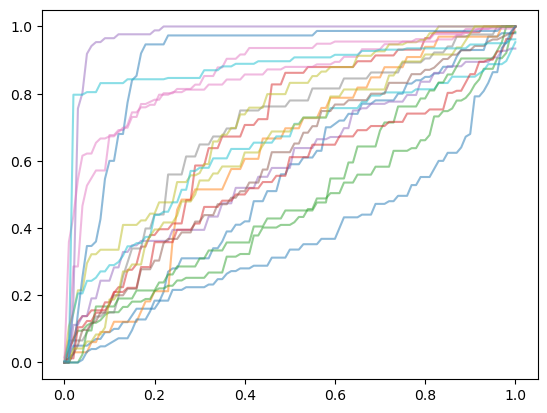

In [318]:
fig, ax = plt.subplots(1, 1)

tprs = []
fpr_std = np.arange(0, 1.01, .01)

for sub in ratio_arrays.keys():
    # if not sub == '014': continue

    temp_tpr, temp_fpr = [], []

    X = ratio_arrays[sub]
    y_true = lid_arrays[sub]

    threshes = np.arange(3, -1, -.01)

    for thresh in threshes:
        y_pred = X > thresh
        # get AUROC variables
        if sum(y_pred) == 0:
            # print('no POS', thresh)
            temp_tpr.append(0)
            temp_fpr.append(0)
        elif sum(y_pred) == len(y_pred):
            # print('only POS', thresh)
            temp_tpr.append(1)
            temp_fpr.append(1)
        else:
            tn, fp, fn, tp = confusion_matrix(y_true.astype(int), y_pred.astype(int)).ravel()
            sens = tp / (tp + fn)  # TPR = sens
            spec = tn / (tn + fp)  # FPR = 1 - spec
            temp_tpr.append(sens)
            temp_fpr.append(1 - spec)
            # print('...', thresh, sens, 1-spec)
    
    # structurend AUROC
    tpr = []
    for x in fpr_std:
        i_x = np.argmin(abs(np.array(temp_fpr) - x))
        tpr.append(temp_tpr[i_x])
    tprs.append(tpr)

    ax.plot(fpr_std, tpr, alpha=.5,)


plt.show()

# plt.plot(fpr_std, np.nanmean(tprs, axis=0))
# plt.plot(fpr_std, np.nanmean(tprs, axis=0) - np.nanstd(tprs, axis=0))
# plt.plot(fpr_std, np.nanmean(tprs, axis=0) + np.nanstd(tprs, axis=0))

Perform LOSO Cross Validation

In [ ]:
from sklearn.metrics import balanced_accuracy_score, classification_report, precision_score, confusion_matrix


In [311]:
METRIC = 'bACC'

cv_opt_thresh = []
cv_train_acc, cv_test_sens, cv_test_spec = [], [], []
cv_test_acc = []
cv_test_subs = []


for test_sub in ratio_arrays.keys():
    print(f'\n.....TEST sub-{test_sub}')
    # get values for test sub
    test_X = ratio_arrays[test_sub]
    test_y_true = lid_arrays[test_sub]

    # get all values for other subs as training
    train_X, train_y_true = [], []

    for train_sub in ratio_arrays.keys():
        if train_sub == test_sub:
            # print(f'... no including sub-{train_sub}')
            continue
        # print(f'include sub-{train_sub} for training :)')

        train_X.extend(ratio_arrays[train_sub])
        train_y_true.extend(lid_arrays[train_sub])
    
    # Training: finding optimal threshold
    train_perf = []
    threshes = np.arange(-2.0, 2.0, .01)

    for thresh in threshes:
        train_y_pred = train_X > thresh
        # get balanced accuracy
        if METRIC == 'bACC':
            thresh_perf = balanced_accuracy_score(train_y_true,
                                                  train_y_pred)
        elif METRIC == 'AUC':
            tn, fp, fn, tp = confusion_matrix(train_y_true, train_y_pred).ravel()
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            thresh_perf = sens * spec  # area under ROC
        
        train_perf.append(thresh_perf)
        # print(f'...train: (thresh: {thresh}) acc: {thresh_acc}')
    
    # find optimal threshold
    i_opt_thresh = np.argmax(train_perf)
    cv_opt_thresh.append(threshes[i_opt_thresh])
    cv_train_acc.append(train_perf[i_opt_thresh])

    # print(f'optimal-training-performance sub-{test_sub}: {train_perf[i_opt_thresh]}'
    #       f' with threshold: {threshes[i_opt_thresh]}\n')

    test_y_pred = test_X > threshes[i_opt_thresh]
    # test_y_pred = test_X > 0
    
    if METRIC == 'bACC':
        test_perf = balanced_accuracy_score(test_y_true, test_y_pred)
    
    # elif METRIC == 'AUC':
    tn, fp, fn, tp = confusion_matrix(test_y_true, test_y_pred).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    auc = sens * spec  # area under ROC

    cv_test_acc.append(test_perf)
    cv_test_sens.append(sens)
    cv_test_spec.append(spec)
    cv_test_subs.append(test_sub)

    print(f'test-performance sub-{test_sub}: {test_perf}')
    print(f'sens: {sens}, spec: {spec}')



.....TEST sub-108
test-performance sub-108: 0.5275000000000001
sens: 0.78, spec: 0.275

.....TEST sub-014
test-performance sub-014: 0.5815047021943573
sens: 0.8181818181818182, spec: 0.3448275862068966

.....TEST sub-022
test-performance sub-022: 0.46288791106993976
sens: 0.3228346456692913, spec: 0.6029411764705882

.....TEST sub-021
test-performance sub-021: 0.5342588446036722
sens: 0.1724137931034483, spec: 0.8961038961038961

.....TEST sub-105
test-performance sub-105: 0.5230263157894737
sens: 0.046052631578947366, spec: 1.0

.....TEST sub-017


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\3655505362.py:62: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)


test-performance sub-017: 0.9156626506024096
sens: nan, spec: 0.9156626506024096

.....TEST sub-009
test-performance sub-009: 0.7072924246099119
sens: 0.43609022556390975, spec: 0.978494623655914

.....TEST sub-110
test-performance sub-110: 0.5238095238095237
sens: 0.09523809523809523, spec: 0.9523809523809523

.....TEST sub-020
test-performance sub-020: 0.6247152268948957
sens: 0.2953020134228188, spec: 0.9541284403669725

.....TEST sub-008
test-performance sub-008: 0.6010235870048954
sens: 0.3925233644859813, spec: 0.8095238095238095

.....TEST sub-010
test-performance sub-010: 0.5720681265206813
sens: 0.17333333333333334, spec: 0.9708029197080292

.....TEST sub-101


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\3655505362.py:62: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)


test-performance sub-101: 0.41578947368421054
sens: nan, spec: 0.41578947368421054

.....TEST sub-016
test-performance sub-016: 0.47625928984310484
sens: 0.35714285714285715, spec: 0.5953757225433526

.....TEST sub-102
test-performance sub-102: 0.5184062850729517
sens: 0.691358024691358, spec: 0.34545454545454546

.....TEST sub-023
test-performance sub-023: 0.8744972897359679
sens: 0.7790697674418605, spec: 0.9699248120300752

.....TEST sub-019
test-performance sub-019: 0.5610182666148464
sens: 0.3870967741935484, spec: 0.7349397590361446

.....TEST sub-107
test-performance sub-107: 0.7966153846153846
sens: 0.7692307692307693, spec: 0.824

.....TEST sub-109


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\habetsj\AppData\Local\Temp\ipykernel_17784\3655505362.py:62: RuntimeWarning: invalid value encountered in longlong_scalars
  sens = tp / (tp + fn)


test-performance sub-109: 0.7024390243902439
sens: nan, spec: 0.7024390243902439

.....TEST sub-013
test-performance sub-013: 0.5941932624113475
sens: 0.3958333333333333, spec: 0.7925531914893617

.....TEST sub-012
test-performance sub-012: 0.8601532567049808
sens: 0.7203065134099617, spec: 1.0

.....TEST sub-103
test-performance sub-103: 0.4806666666666667
sens: 0.128, spec: 0.8333333333333334


Permutation testing

In [322]:
### executing permutations with shuffled ratios

np.random.seed(27)
N_PERM = 5000

perm_perfs = {}

for i_sub, test_sub in enumerate(ratio_arrays.keys()):
    print(f'\n.....TEST sub-{test_sub}')    
    perm_perfs[test_sub] = []

    for i_perm in np.arange(N_PERM):
        # get values for test sub
        test_X = ratio_arrays[test_sub].copy()
        np.random.shuffle(test_X)
        test_y_true = lid_arrays[test_sub]

        perm_y_pred = test_X > cv_opt_thresh[i_sub]
        perm_perfs[test_sub].append(balanced_accuracy_score(test_y_true, perm_y_pred))
        # print(f'perm {i_perm} - performance sub-{test_sub}: {perm_perf}')


.....TEST sub-108

.....TEST sub-014

.....TEST sub-022

.....TEST sub-021

.....TEST sub-105

.....TEST sub-017


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.w


.....TEST sub-009

.....TEST sub-110

.....TEST sub-020

.....TEST sub-008

.....TEST sub-010

.....TEST sub-101


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.w


.....TEST sub-016

.....TEST sub-102

.....TEST sub-023

.....TEST sub-019

.....TEST sub-107

.....TEST sub-109


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.w


.....TEST sub-013

.....TEST sub-012

.....TEST sub-103


In [329]:
# defining p-values based on permutations

res_out = {"sub": [], "acc": [], "acc_p": [], "sens": [], "spec": []}

cv_test_ps = []

for i, sub in enumerate(perm_perfs):

    test_perf = cv_test_acc[i]
    perms = perm_perfs[sub]

    p = sum(test_perf < perms) / len(perms)
    cv_test_ps.append(p)

    res_out['sub'].append(sub)
    res_out['acc'].append(test_perf)
    res_out['acc_p'].append(p)
    res_out['sens'].append(cv_test_sens[i])
    res_out['spec'].append(cv_test_spec[i])

    print(f'sub-{sub}: accuracy: {round(test_perf, 2)} (p={p}),\tsens: {cv_test_sens[i]},\tspec: {cv_test_spec[i]}')

print(f'\nGroup Bal. Accuracy: {round(np.mean(cv_test_acc), 2)}, sd={round(np.std(cv_test_acc), 2)}')
print(f'Group Sensitivity: {round(np.nanmean(cv_test_sens), 2)}, sd={round(np.nanstd(cv_test_sens), 2)}')
print(f'Group Specificity: {round(np.mean(cv_test_spec), 2)}, sd={round(np.std(cv_test_spec), 2)}')

### STORE RESULTS as JSON
# fname = os.path.join(utilsFiles.get_project_path('data'), 'prediction_data', 'ratio_pred_results.json')

# with open(fname, 'wt') as f:
#     json.dump(res_out, f)


sub-108: accuracy: 0.53 (p=0.1324),	sens: 0.78,	spec: 0.275
sub-014: accuracy: 0.58 (p=0.0188),	sens: 0.8181818181818182,	spec: 0.3448275862068966
sub-022: accuracy: 0.46 (p=0.8694),	sens: 0.3228346456692913,	spec: 0.6029411764705882
sub-021: accuracy: 0.53 (p=0.059),	sens: 0.1724137931034483,	spec: 0.8961038961038961
sub-105: accuracy: 0.52 (p=0.0),	sens: 0.046052631578947366,	spec: 1.0
sub-017: accuracy: 0.92 (p=0.0),	sens: nan,	spec: 0.9156626506024096
sub-009: accuracy: 0.71 (p=0.0),	sens: 0.43609022556390975,	spec: 0.978494623655914
sub-110: accuracy: 0.52 (p=0.0554),	sens: 0.09523809523809523,	spec: 0.9523809523809523
sub-020: accuracy: 0.62 (p=0.0),	sens: 0.2953020134228188,	spec: 0.9541284403669725
sub-008: accuracy: 0.6 (p=0.001),	sens: 0.3925233644859813,	spec: 0.8095238095238095
sub-010: accuracy: 0.57 (p=0.0),	sens: 0.17333333333333334,	spec: 0.9708029197080292
sub-101: accuracy: 0.42 (p=0.0),	sens: nan,	spec: 0.41578947368421054
sub-016: accuracy: 0.48 (p=0.6484),	sens: 0.

'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\figures\\final_Q1_2024\\prediction\\ratio'

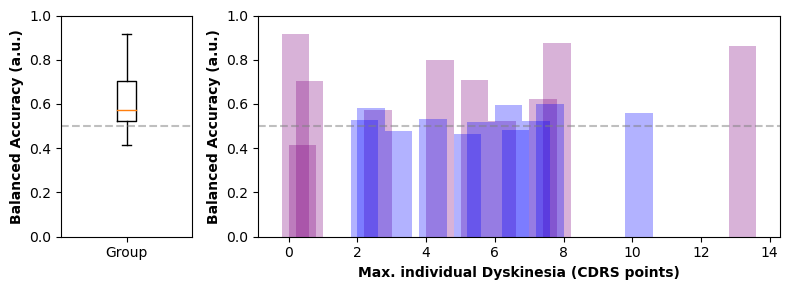

In [325]:
FIGNAME = '0919_ratio_pred_groupBox_indBars'

fig, axes = plt.subplots(
    1, 2, figsize=(8, 3),
    gridspec_kw={'width_ratios': [1, 4]}
)

axes[0].boxplot(cv_test_acc, labels=['Group'])

bars_x, bars_y = [], []
bars_x_ns, bars_y_ns = [], []
all_x = []

for s, v, p in zip(cv_test_subs, cv_test_acc, cv_test_ps):
    cdrs_times, cdrs_scores = importClin.get_cdrs_specific(sub=s, INCL_CORE_CDRS=True,)
    max_lid = max(cdrs_scores)
    all_x.append(max_lid)
    # get x-deviation if value doubles
    w = sum(np.array(all_x) == max_lid)
    max_lid += (.2 * w)

    if p < (.01 / 21):
        bars_x.append(max_lid)
        bars_y.append(v)
    else:
        bars_x_ns.append(max_lid)
        bars_y_ns.append(v)

axes[1].bar(bars_x, height=bars_y, alpha=.3, facecolor='purple',)
axes[1].bar(bars_x_ns, height=bars_y_ns, 
            # facecolor='None', edgecolor='darkgreen', hatch='/', alpha=.8,
            facecolor='blue', alpha=.3,
)


axes[1].set_xlabel('Max. individual Dyskinesia (CDRS points)',
                   weight='bold',)


for ax in axes:
    ax.set_ylim(0, 1)
    ax.set_ylabel('Balanced Accuracy (a.u.)', weight='bold',)
    ax.axhline(0.5, ls='--', c='gray', alpha=.5,)

plt.tight_layout()

plt.savefig(os.path.join(utilsFiles.get_project_path('figures'),
            'final_Q1_2024', 'prediction', 'ratio', FIGNAME),
            dpi=300, facecolor='w',)

plt.show()

## Old)

Extract Spectral Power and Variation in Feature windows

TODO:
- current gamma: only indiv peak, add sum gamma over 60 - 90

In [ ]:
def indiv_zscoring_feats(X_arr, sub_arr):

    for i_f, sub in product(np.arange(X_arr.shape[1]),
                            np.unique(sub_arr)):
        # loop over all feature and sub combinations
        sub_sel = sub_arr == sub
        m = np.mean(X_arr[sub_sel, i_f])
        sd = np.std(X_arr[sub_sel, i_f])
        # z-score values for sub
        X_arr[sub_sel, i_f] = (X_arr[sub_sel, i_f] - m) / sd
    
    return X_arr

In [ ]:
importlib.reload(ssdFeats)

X_arrs, y_arrs, sub_arrs = {}, {}, {}
mov_dep_code = {}

for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
    # loading/ creating/ saving in ssdFeats script
    (
        X_arrs[i_mov], y_arrs[i_mov], sub_arrs[i_mov], feat_names
    ) = ssdFeats.get_moveSpec_predArrays(
        MOV_SEL=MOV_SEL, LOAD_SOURCES=['STN',],
        POWER_METHOD='ENV'
    )
    # add movement code
    mov_dep_code[i_mov] = np.array([i_mov] * X_arrs[i_mov]['STN'].shape[0]).T

# merging for zscoring together
stn_X = np.concatenate([X_arrs[0]['STN'], X_arrs[1]['STN']], axis=0)
stn_y = np.concatenate([y_arrs[0]['STN'], y_arrs[1]['STN']], axis=0)
stn_subids = np.concatenate([sub_arrs[0]['STN'], sub_arrs[1]['STN']], axis=0)

mov_dep_code = np.concatenate([mov_dep_code[0], mov_dep_code[1]], axis=0)

In [ ]:
# calculate coefficients and pvalues
CDRS_categs = {0: 'none', 1: 'mild',
               2: 'moderate', 3: 'severe'}

X = stn_X.copy()
y = stn_y.copy()
sub_ids = stn_subids.copy()

stat_arr = {'INDEP': {'coef': [], 'pval': []},
            'DEPEND': {'coef': [], 'pval': []}}

X = indiv_zscoring_feats(X, sub_arr=sub_ids)

for i_ft, ft in enumerate(feat_names['STN']):
    

    for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
        mov_bool = mov_dep_code == i_mov
        # define X and groups for feat
        ft_temp = X[mov_bool, i_ft]
        y_temp = y[mov_bool]
        box_categs = [ft_temp[y_temp == cat]
                      for cat in CDRS_categs.keys()]
        # run LMM
        coeff, pval = lidStats.run_mixEff_wGroups(
            dep_var=ft_temp,
            indep_var=y_temp,
            groups=sub_ids[mov_bool],
            TO_ZSCORE=False,
        )
        # save in dict-lists
        stat_arr[MOV_SEL]['coef'].append(coeff)
        stat_arr[MOV_SEL]['pval'].append(pval)

        

In [ ]:
# plot boxplots per feature

FIG_NAME = '0129env_boxplots_specPowerVar_vs_LIDcategs'


fig, axes = plt.subplots(len(feat_names['STN']), 2,
                         figsize=(12, 18),
                         sharex='col', sharey='row')

for i_ft, ft in enumerate(feat_names['STN']):
    
    for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
        # get boxplot data
        mov_bool = mov_dep_code == i_mov
        # define X and groups for feat
        ft_temp = X[mov_bool, i_ft]
        y_temp = y[mov_bool]
        box_categs = [ft_temp[y_temp == cat]
                      for cat in CDRS_categs.keys()]
        
        # stats are calculated before

        # plotting
        coeff = stat_arr[MOV_SEL]['coef'][i_ft]
        pval = stat_arr[MOV_SEL]['pval'][i_ft]
        axes[i_ft, i_mov].boxplot(box_categs)
        if pval < (.05 / len(feat_names['STN'])): w = 'bold'
        else: w='normal'
        axes[i_ft, i_mov].set_title(f'{ft}, mov-{MOV_SEL}\n'
                f'(coeff {round(coeff, 2)}, '
                f'p={round(pval, 5)})',
                weight=w,)
        axes[i_ft, i_mov].set_ylim(-3, 3)

        axes[i_ft, i_mov].set_xticks([1,2,3,4])
        axes[i_ft, i_mov].set_xticklabels(CDRS_categs.values())
        axes[i_ft, i_mov].set_ylabel('indiv. z-scored feature\n(a.u.)')
        axes[i_ft, i_mov].set_xlabel('LID (CDRS sum)')

plt.tight_layout()

plt.savefig(os.path.join(utilsFiles.get_project_path('figures'),
                            'feat_dysk_corrs',
                            'corr_boxplots',
                            FIG_NAME),
            dpi=300, facecolor='w',)

plt.close()
        

In [ ]:
# plot HEATMAP

FIG_NAME = '0129cf_heatmap_specPowerVar_vs_LIDcategs'


fig, ax = plt.subplots(1, 1,
                         figsize=(12, 4),)
ALPHA = .05 / len(feat_names['STN'])
# 0 is not sign, 1 is sign
heat_arrs = {sig_label: np.array([
    [np.nan] * len(feat_names['STN'])
] * 2) for sig_label in [0, 1]}

for i_ft, ft in enumerate(feat_names['STN']):
    
    for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
        # fill arrays with stats calculated before
        coeff = stat_arr[MOV_SEL]['coef'][i_ft]
        pval = stat_arr[MOV_SEL]['pval'][i_ft]
        sig_lab = (pval < ALPHA).astype(int)
        heat_arrs[sig_lab][i_mov, i_ft] = coeff

# non-sign heatmap
vmin, vmax = -.25, .25
cmap = 'coolwarm'  # RdBu_r
nonsig_map = ax.imshow(heat_arrs[0], vmin=vmin, vmax=vmax,
                           cmap=cmap, )
# hatch = plt.pcolor(heat_arrs[0], vmin=vmin, vmax=vmax,
#                    hatch='//', cmap=cmap,
#                    edgecolor='w', )

# ax.imshow(X=heat_arrs[0], cmap='coolwarm',
        #   alpha=.6, vmin=-.3, vmax=.3,)
sig_map = ax.imshow(X=heat_arrs[1], cmap=cmap,  # RdBu_r
                    alpha=.9, vmin=vmin, vmax=vmax,)

for i_m, i_f in product(np.arange(heat_arrs[1].shape[0]),
                        np.arange(heat_arrs[1].shape[1])):
    if np.isnan(heat_arrs[1][i_m, i_f]): continue
    if abs(heat_arrs[1][i_m, i_f]) > .3: c='w'
    else: c = 'black'
    ax.text(i_f, i_m, s=round(heat_arrs[1][i_m, i_f], 2),
            color=c, horizontalalignment='center',
            verticalalignment='center', weight='bold',)

cbar = fig.colorbar(sig_map, pad=.01)
cbar.ax.set_ylabel('LMM coefficient (a.u.)')

ax.set_xticks(np.arange(len(feat_names['STN'])))
ax.set_xticklabels(feat_names['STN'],
                   rotation=75,)
ax.set_yticks([0, 1])
ax.set_yticklabels(['move-INDEPENDENT', 'move-DEPENDENT'],)

plt.tight_layout()

plt.savefig(os.path.join(utilsFiles.get_project_path('figures'),
                            'feat_dysk_corrs',
                            'corr_boxplots',
                            FIG_NAME),
            dpi=300, facecolor='w',)

plt.close()
        

In [ ]:
heat_arrs[1].shape